In [177]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from architecture.MLP import FCNet
from utils import get_data, plotter
from collections import OrderedDict
from matplotlib import cm
from matplotlib.colors import Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")

In [178]:
dataset = "gaussian"
width = 512

train_loader, test_loader = get_data(dataset, 512)

# choose two random indices from 0 to 49
idx1 = np.random.randint(0, 50)
idx2 = np.random.randint(0, 50)
while idx1 == idx2:
    idx2 = np.random.randint(0, 50)

# load both models
model1 = FCNet(2, width, 1, 1)
model2 = FCNet(2, width, 1, 1)

model1.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{idx1}.pth")
)
model2.load_state_dict(
    torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{idx2}.pth")
)

average_model = FCNet(2, width, 1, 1)
average_state_dict = OrderedDict()
for key in model1.state_dict():
    average_state_dict[key] = (model1.state_dict()[key] + model2.state_dict()[key]) / 2
average_model.load_state_dict(average_state_dict)

<All keys matched successfully>

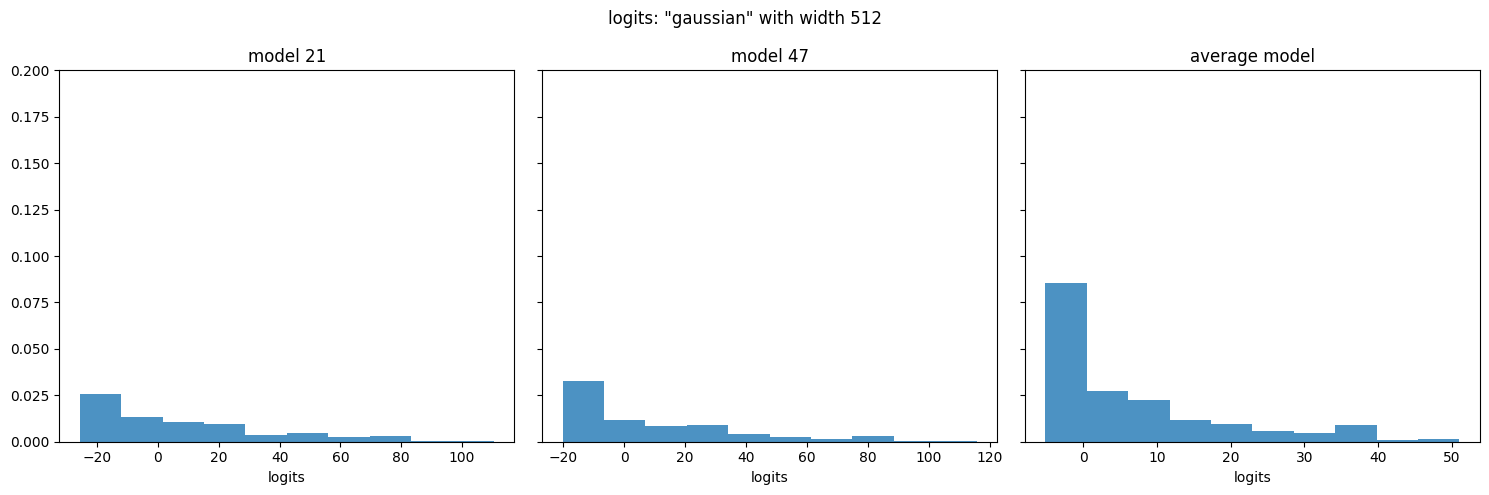

In [179]:
# plot the output distributions of the models side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
axs[0].set_title(f"model {idx1}")
axs[1].set_title(f"model {idx2}")
axs[2].set_title(f"average model")
for i, model in enumerate([model1, model2, average_model]):
    model.eval().to(device)
    out = []
    with torch.no_grad():
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1).float()
            y_hat = model(x)
            out.append(y_hat.cpu().numpy())
    out = np.concatenate(out)
    # plot the output distribution
    axs[i].hist(out, bins=10, density=True, alpha=0.8)
    axs[i].set_xlabel("logits")
    axs[i].set_ylim(0, 0.2)
# title
fig.suptitle(f"logits: \"{dataset}\" with width {width}")
plt.tight_layout()
plt.show()


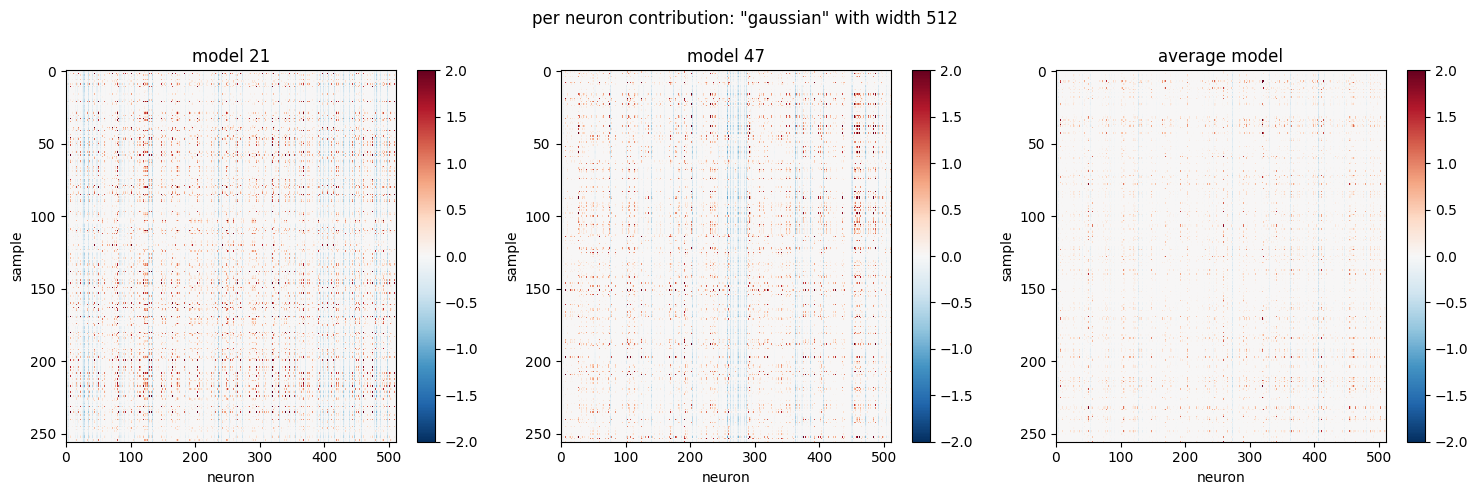

In [180]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title(f"model {idx1}")
axs[1].set_title(f"model {idx2}")
axs[2].set_title(f"average model")

for i, model in enumerate([model1, model2, average_model]):
    model.eval().to(device)
    out = []
    with torch.no_grad():
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).unsqueeze(1).float()
            a = torch.relu(model.layers[0](x))
            out.append(a.cpu().numpy())
    out = np.concatenate(out)
    # multiplyt with output weights
    out = out * model.layers[1].weight.detach().cpu().numpy()
    
    # plot as heatmap
    axs[i].imshow(out, aspect="auto", cmap="RdBu_r", interpolation="none", vmin=-2, vmax=2)
    # colorbar with min and max as -2 and 2
    cbar = axs[i].figure.colorbar(cm.ScalarMappable(cmap="RdBu_r", norm=Normalize(vmin=-2, vmax=2)), ax=axs[i])
    # labels
    axs[i].set_xlabel("neuron")
    axs[i].set_ylabel("sample")

# title
fig.suptitle(f"per neuron contribution: \"{dataset}\" with width {width}")
plt.tight_layout()
plt.show()

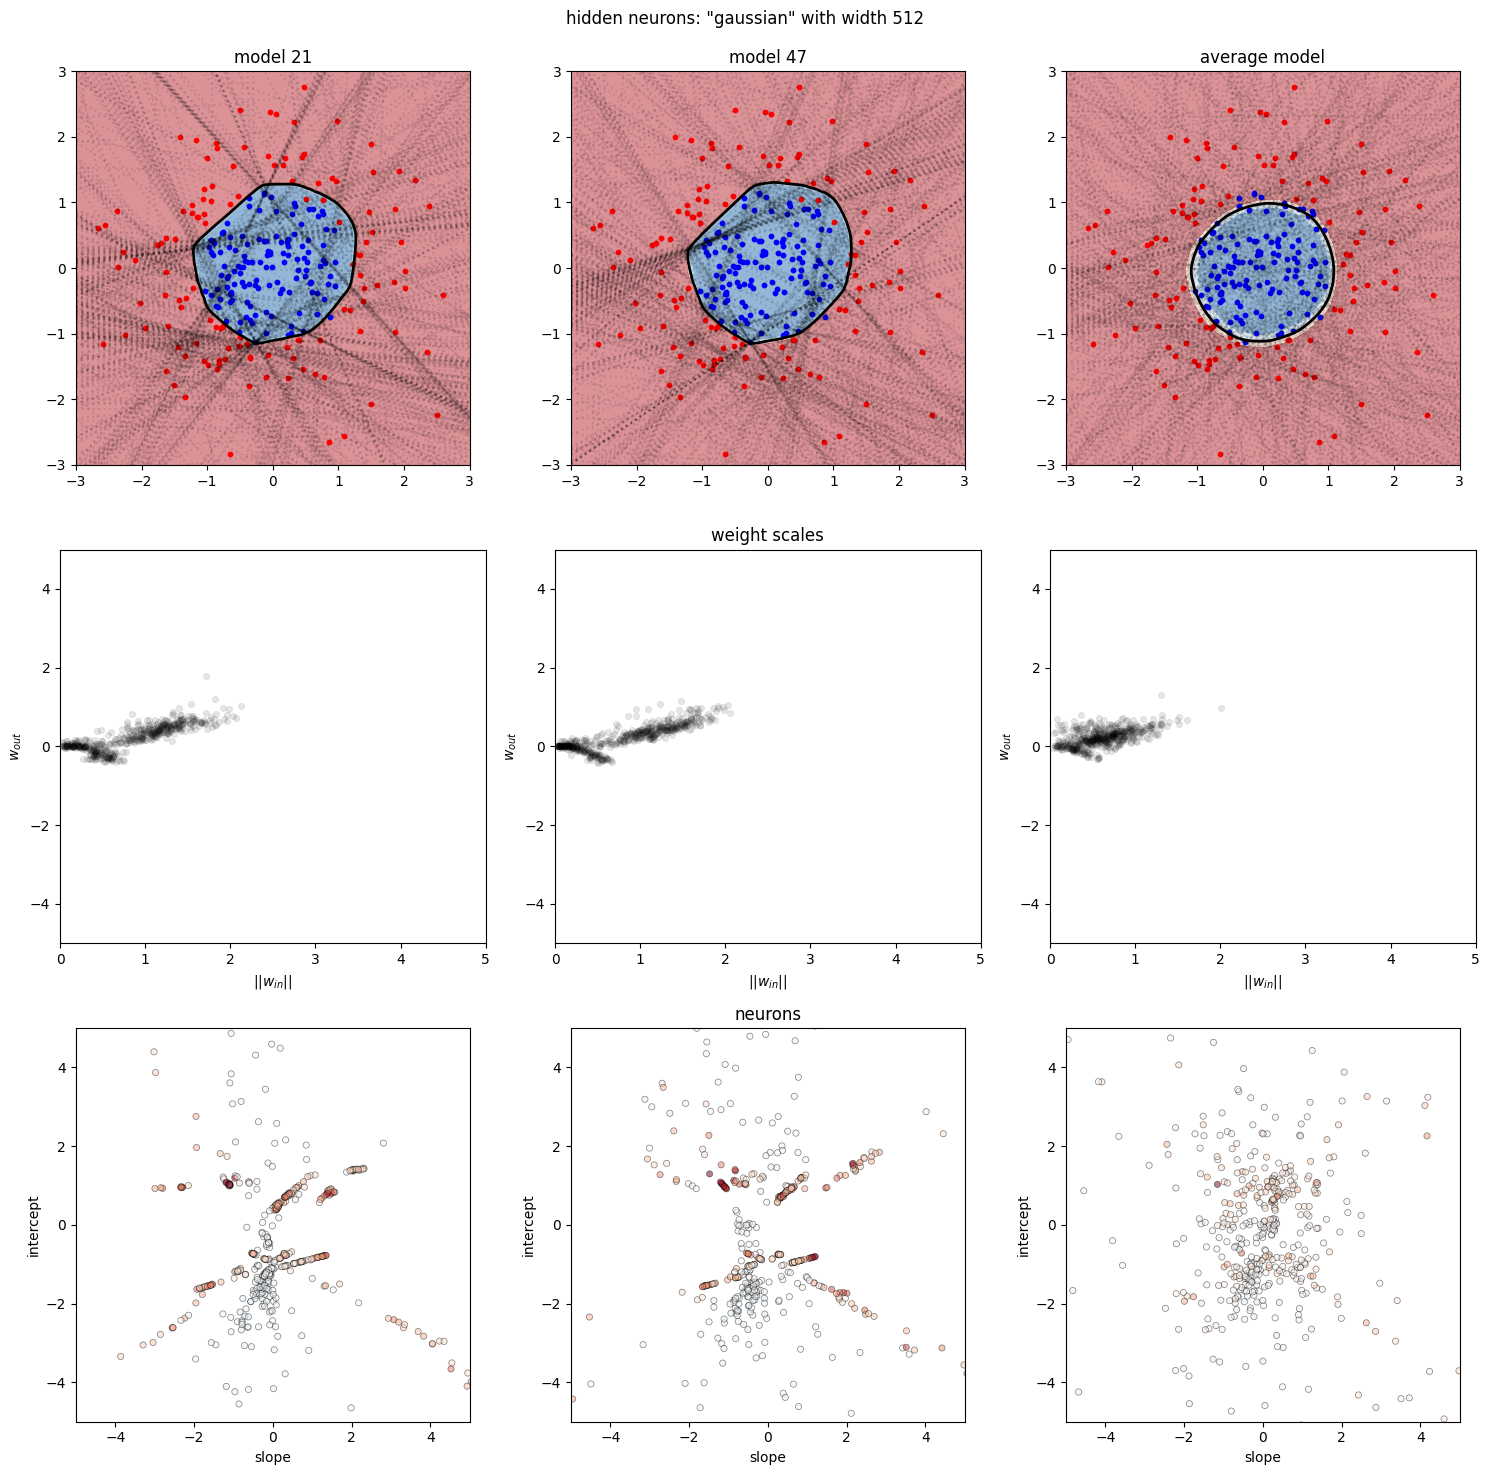

In [181]:
# plot all three for all three models
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 15)

# set titles for each row
axs[0, 0].set_title(f"model {idx1}")
axs[0, 1].set_title(f"model {idx2}")
axs[0, 2].set_title(f"average model")

axs[1, 1].set_title(f"weight scales")
axs[2, 1].set_title(f"neurons")

for i, model in enumerate([model1, model2, average_model]):
    # decision boundary
    model.eval().to(device)
    x1 = np.linspace(-3, 3, 100)
    x2 = np.linspace(-3, 3, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
    X = torch.from_numpy(X).float().to(device)
    y = model(X).detach().cpu().numpy().reshape(100, 100)
    # apply sigmoid
    y = 1 / (1 + np.exp(-y))

    w_in = model.layers[0].weight.detach().cpu().numpy()
    w_in_norm = np.linalg.norm(w_in, axis=1)
    b_in = model.layers[0].bias.detach().cpu().numpy()
    w_out = model.layers[1].weight.detach().cpu().numpy()
    w_out = np.squeeze(w_out)
    # plot the lines corresponding to each hidden node
    for j in range(width):
        axs[0, i].plot(
            x1,
            -(w_in[j, 0] * x1 + b_in[j]) / w_in[j, 1],
            linestyle="dotted",
            alpha=0.1,
            c="k",
        )
    axs[0, i].contourf(x1, x2, y, 3, cmap="RdBu_r", alpha=0.5)
    # highlight line at 0.5
    axs[0, i].contour(x1, x2, y, levels=[0.5], colors="k", linewidths=2)
    axs[0, i].set_aspect("equal")
    axs[0, i].set_xlim(-3, 3)
    axs[0, i].set_ylim(-3, 3)

    # plot the training data
    for x_, y_ in train_loader:
        x_ = x_.numpy()
        y_ = y_.numpy()
        axs[0, i].scatter(x_[y_ == 0, 0], x_[y_ == 0, 1], c="b", s=10)
        axs[0, i].scatter(x_[y_ == 1, 0], x_[y_ == 1, 1], c="r", s=10)

    # in second row, plot w_in norm vs w_out
    axs[1, i].scatter(
        w_in_norm, w_out, c="k", alpha=0.1, s=20, edgecolors="k", linewidths=0.5
    )
    axs[1, i].set_xlabel("$\|| w_{in} \||$")
    axs[1, i].set_ylabel("$w_{out}$")
    axs[1, i].set_xlim(0, 5)
    axs[1, i].set_ylim(-5, 5)

    slope = -w_in[:, 0] / w_in[:, 1]
    intercept = -b_in / w_in[:, 1]
    # in third row, plot neurons as (slope, y_intercept) and color as (w_in norm * w_out)
    axs[2, i].scatter(
        slope,
        intercept,
        c=w_in_norm * w_out,
        cmap="RdBu_r",
        s=20,
        vmin=-2,
        vmax=2,
        alpha=0.5,
        edgecolors="k",
        linewidths=0.5,
    )
    axs[2, i].set_aspect("equal")
    axs[2, i].set_xlim(-5, 5)
    axs[2, i].set_ylim(-5, 5)
    axs[2, i].set_xlabel("slope")
    axs[2, i].set_ylabel("intercept")
fig.suptitle(f"hidden neurons: \"{dataset}\" with width {width}\n")
plt.tight_layout()
plt.show()

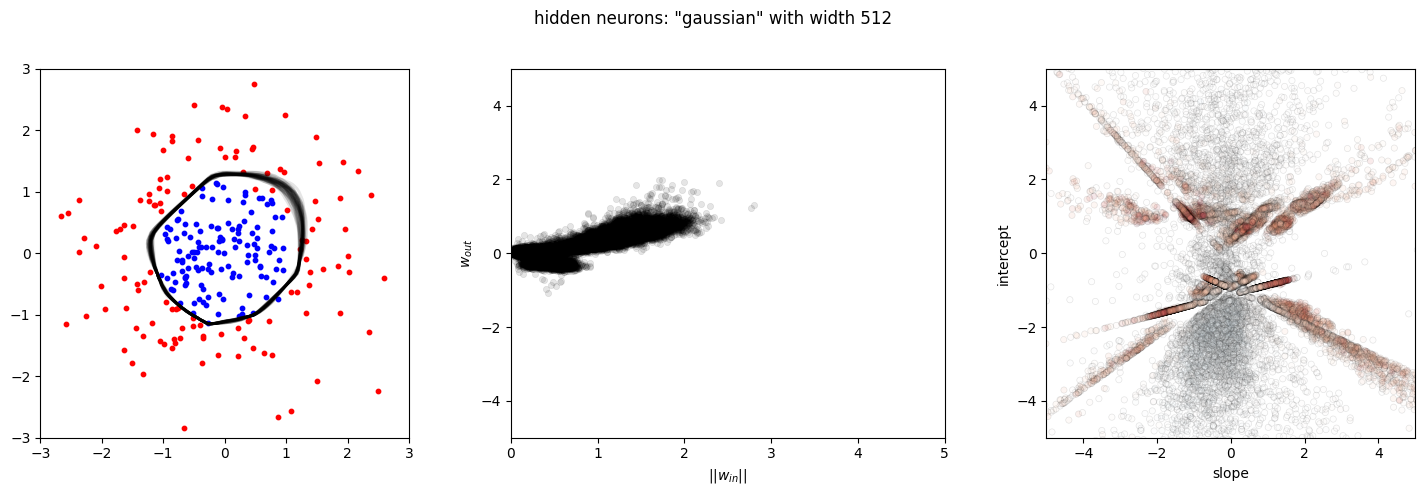

In [182]:
# for given dataset and width, plot all models
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

    
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
X = torch.from_numpy(X).float().to(device)

axs[0].set_aspect("equal")
axs[0].set_xlim(-3, 3)
axs[0].set_ylim(-3, 3)

axs[1].set_xlabel("$\|| w_{in} \||$")
axs[1].set_ylabel("$w_{out}$")
axs[1].set_xlim(0, 5)
axs[1].set_ylim(-5, 5)

axs[2].set_aspect("equal")
axs[2].set_xlim(-5, 5)
axs[2].set_ylim(-5, 5)
axs[2].set_xlabel("slope")
axs[2].set_ylabel("intercept")

# plot the training data
for x_, y_ in train_loader:
    x_ = x_.numpy()
    y_ = y_.numpy()
    axs[0].scatter(x_[y_ == 0, 0], x_[y_ == 0, 1], c="b", s=10)
    axs[0].scatter(x_[y_ == 1, 0], x_[y_ == 1, 1], c="r", s=10)

for i in range(50):
    model = FCNet(2, width, 1, 1)
    model.load_state_dict(torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{i}.pth"))
    model.eval().to(device)
    # decision boundary
    y = model(X).detach().cpu().numpy().reshape(100, 100)
    # apply sigmoid
    y = 1 / (1 + np.exp(-y))

    w_in = model.layers[0].weight.detach().cpu().numpy()
    w_in_norm = np.linalg.norm(w_in, axis=1)
    b_in = model.layers[0].bias.detach().cpu().numpy()
    w_out = model.layers[1].weight.detach().cpu().numpy()
    w_out = np.squeeze(w_out)

    # highlight line at 0.5
    axs[0].contour(x1, x2, y, levels=[0.5], colors="k", linewidths=2, alpha=0.1)

    # in second column, plot w_in norm vs w_out
    axs[1].scatter(
        w_in_norm, w_out, c="k", alpha=0.1, s=20, edgecolors="k", linewidths=0.5
    )

    slope = -w_in[:, 0] / w_in[:, 1]
    intercept = -b_in / w_in[:, 1]
    # in third column, plot neurons as (slope, y_intercept) and color as (w_in norm * w_out)
    axs[2].scatter(
        slope,
        intercept,
        c=w_in_norm * w_out,
        cmap="RdBu_r",
        s=20,
        vmin=-2,
        vmax=2,
        alpha=0.1,
        edgecolors="k",
        linewidths=0.5,
    )

fig.suptitle(f"hidden neurons: \"{dataset}\" with width {width}\n")
plt.tight_layout()
plt.show()

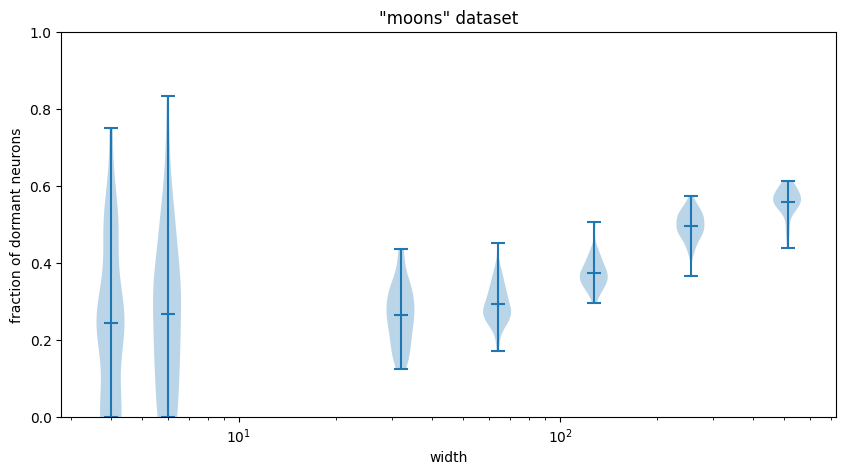

In [183]:
dataset = "moons"
widths = [4, 6, 32, 64, 128, 256, 512]

# count fraction of neurons that are low scaling (dormant)
fracs = []

for width in widths:
    dormant_fraction = []
    for i in range(50):
        model = FCNet(2, width, 1, 1)
        model.load_state_dict(torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{i}.pth"))
        model.eval().to(device)

        w_in = model.layers[0].weight.detach().cpu().numpy()
        w_in_norm = np.linalg.norm(w_in, axis=1)
        b_in = model.layers[0].bias.detach().cpu().numpy()
        w_out = model.layers[1].weight.detach().cpu().numpy()
        w_out = np.squeeze(w_out)
        scale = w_in_norm * w_out
        dormant_fraction.append(np.sum(np.abs(scale) < 0.2) / scale.shape[0])

    fracs.append(dormant_fraction)

# violin plot of fracs
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.violinplot(fracs, widths, widths=np.array(widths)/5.0, showmeans=True)
ax.set_xlabel("width")
ax.set_xscale("log")
ax.set_ylabel("fraction of dormant neurons")
ax.set_ylim(0, 1)
ax.set_title(f"\"{dataset}\" dataset")
plt.show()

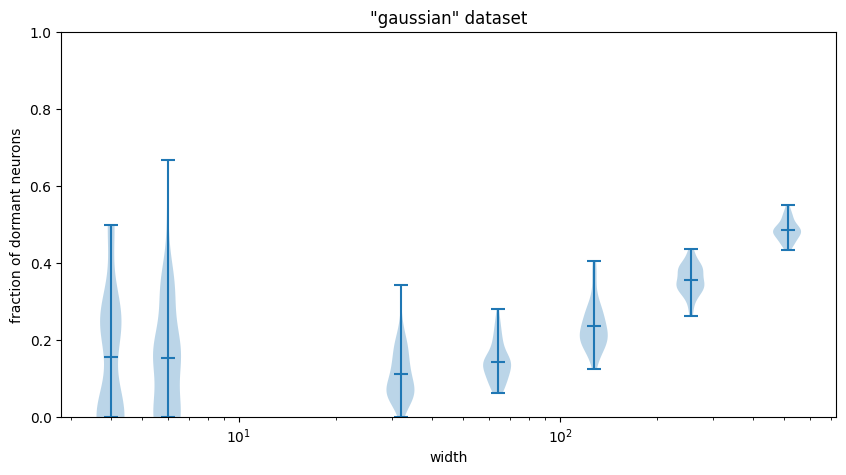

In [184]:
dataset = "gaussian"
widths = [4, 6, 32, 64, 128, 256, 512]

# count fraction of neurons that are low scaling (dormant)
fracs = []

for width in widths:
    dormant_fraction = []
    for i in range(50):
        model = FCNet(2, width, 1, 1)
        model.load_state_dict(torch.load(f"models/sigmoid/{dataset}/model_s512_w{width}_d1_{i}.pth"))
        model.eval().to(device)

        w_in = model.layers[0].weight.detach().cpu().numpy()
        w_in_norm = np.linalg.norm(w_in, axis=1)
        b_in = model.layers[0].bias.detach().cpu().numpy()
        w_out = model.layers[1].weight.detach().cpu().numpy()
        w_out = np.squeeze(w_out)
        scale = w_in_norm * w_out
        dormant_fraction.append(np.sum(np.abs(scale) < 0.2) / scale.shape[0])

    fracs.append(dormant_fraction)

# violin plot of fracs
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.violinplot(fracs, widths, widths=np.array(widths)/5.0, showmeans=True)
ax.set_xlabel("width")
ax.set_xscale("log")
ax.set_ylabel("fraction of dormant neurons")
ax.set_ylim(0, 1)
ax.set_title(f"\"{dataset}\" dataset")
plt.show()

In [185]:
import seaborn as sns
import pandas as pd

dataset = "gaussian"
width = 512
tau = 0.6

In [186]:
w_in = model1.layers[0].weight.detach().cpu().numpy().squeeze()
w_in_norm = np.linalg.norm(w_in, axis=1)
b_in = model1.layers[0].bias.detach().cpu().numpy().squeeze()
w_out = model1.layers[1].weight.detach().cpu().numpy().squeeze()

w_in_0_ = np.abs(w_in[:, 0])
w_in_1_ = np.abs(w_in[:, 1])
b_in_ = np.abs(b_in)

magnitude = w_in_0_ + w_in_1_ + b_in_
dormant = np.sum(magnitude < tau)/width
print(idx1, dormant)

21 0.107421875


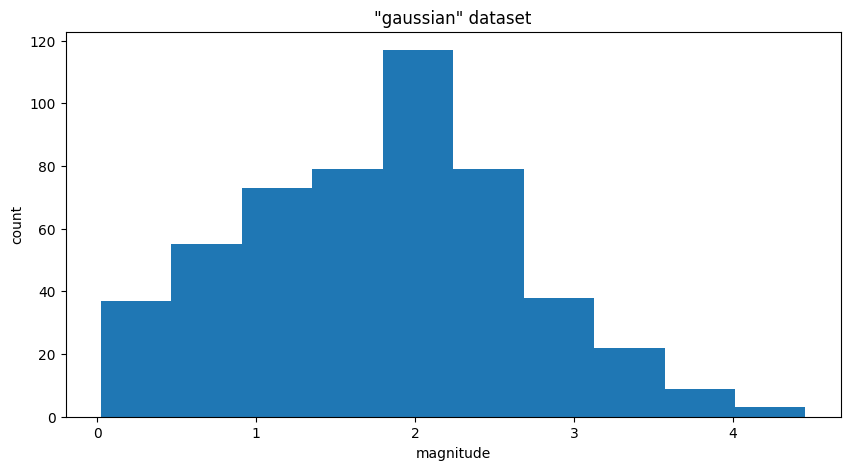

In [187]:
# magnitude histogram
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.hist(magnitude, bins=10)
ax.set_xlabel("magnitude")
ax.set_ylabel("count")
ax.set_title(f"\"{dataset}\" dataset")
plt.show()


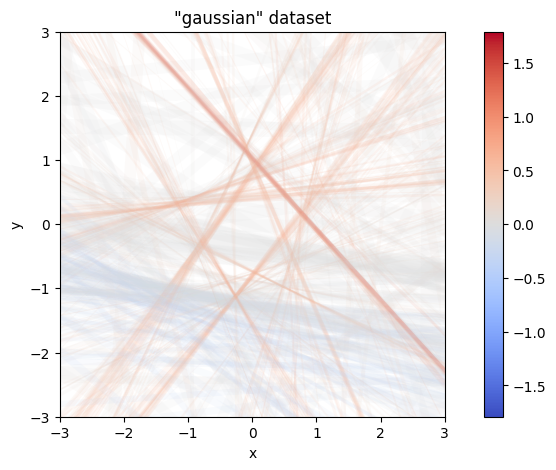

In [188]:
# plot hyperplanes for each neuron
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

# y = - w_in_0 * x / w_in_1 - b_in / w_in_1
x = np.linspace(-3, 3, 100)
for i in range(width):
    y = - w_in[i, 0] * x / w_in[i, 1] - b_in[i] / w_in[i, 1]
    # line width is proportional to w_in norm
    linewidth = np.log(w_in_norm[i])*5
    # map any scale of w_out to colormap range
    mx = np.max(np.abs(w_out))
    color = plt.cm.coolwarm((w_out[i] + mx) / (2 * mx))
    # plot line
    ax.plot(x, y, color=color, linewidth=linewidth, alpha=0.1)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=-mx, vmax=mx))
sm.set_array([])
fig.colorbar(sm, ax=ax)
ax.set_title(f"\"{dataset}\" dataset")
# aspect ratio
ax.set_aspect('equal', 'box')
plt.show()

511 0.1171875


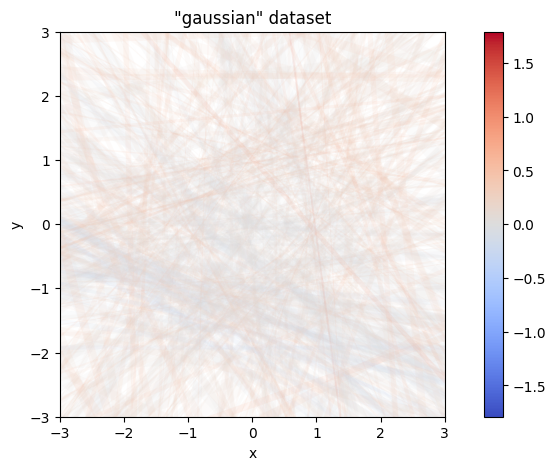

In [189]:
# count fraction of neurons that are low weights
w_in = average_model.layers[0].weight.detach().cpu().numpy().squeeze()
w_in_norm = np.linalg.norm(w_in, axis=1)
b_in = average_model.layers[0].bias.detach().cpu().numpy().squeeze()
w_out = average_model.layers[1].weight.detach().cpu().numpy().squeeze()

w_in_0_ = np.abs(w_in[:, 0])
w_in_1_ = np.abs(w_in[:, 1])
b_in_ = np.abs(b_in)

magnitude = w_in_0_ + w_in_1_ + b_in_
dormant = np.sum(magnitude < tau)/width
print(i, dormant)

# plot hyperplanes for each neuron
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

# y = - w_in_0 * x / w_in_1 - b_in / w_in_1
x = np.linspace(-3, 3, 100)
for i in range(width):
    y = - w_in[i, 0] * x / w_in[i, 1] - b_in[i] / w_in[i, 1]
    # line width is proportional to w_in norm
    linewidth = np.log(w_in_norm[i])*5
    # map any scale of w_out to colormap range
    color = plt.cm.coolwarm((w_out[i] + mx) / (2 * mx))
    # plot line
    ax.plot(x, y, color=color, linewidth=linewidth, alpha=0.1)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
# colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=-mx, vmax=mx))
sm.set_array([])
fig.colorbar(sm, ax=ax)
ax.set_title(f"\"{dataset}\" dataset")
# aspect ratio
ax.set_aspect('equal', 'box')
plt.show()

In [1]:
import numpy as np
from utils import get_data
import matplotlib.pyplot as plt

In [2]:
train_loader, test_loader = get_data("pentagon", 512)

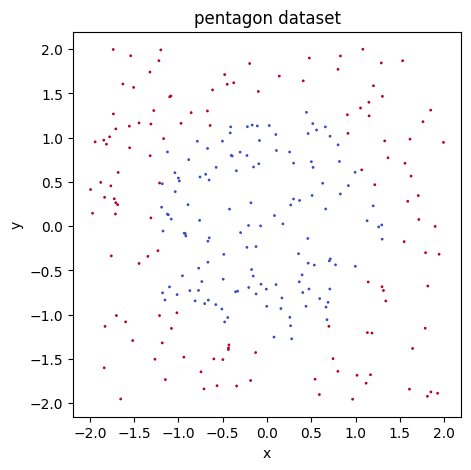

In [8]:
# plot data
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
for x, y in train_loader:
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("pentagon dataset")
# aspect ratio
ax.set_aspect('equal', 'box')
plt.show()


In [9]:
# in train loader, how many are class 0
count0 = 0
count1 = 0
for x, y in train_loader:
    y = y.squeeze().detach().cpu().numpy().astype(int)
    count0 += np.sum(y == 0)
    count1 += np.sum(y == 1)
print(count0, count1)

130 126
